## DeepDream

* **DeepDream** es una **técnica artística de modificación de imágenes** que utiliza las **representaciones aprendidas por las redes neuronales convolucionales**. 
* **Google** lo lanzó por primera vez en el **verano de 2015** [Alexander Mordvintsev, Christopher Olah y Mike Tyka, "DeepDream: A Code Example for Visualizing Neural Networks", Google Research Blog, 1 de julio de 2015](http://mng.bz/xXlM)
* Los resultados de DeepDream convent corresponden al hecho de haber sido entrenado en ImageNet, donde las razas de perros y las especies de aves están ampliamente sobrerrepresentadas.

**Ejemplo de una imagen de salida de DeepDream**

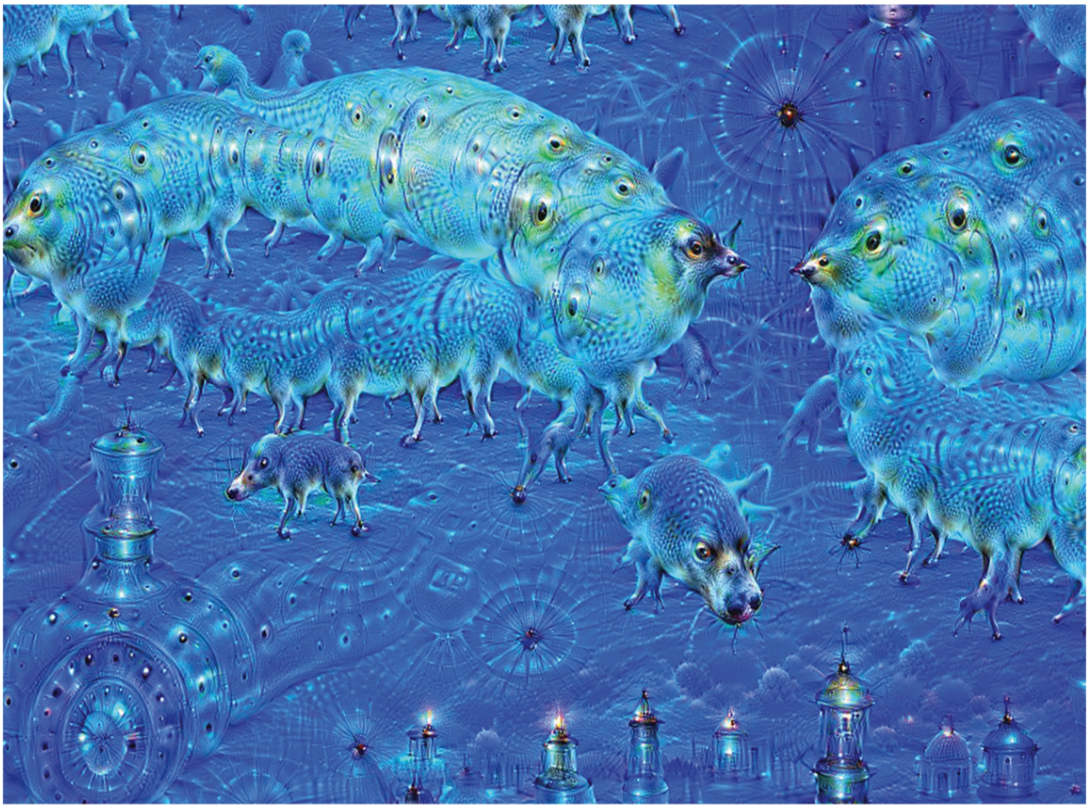

* El algoritmo DeepDream se basa en la **técnica de visualización-filtro de convnet**, que consiste en **ejecutar un convnet a la inversa**: hacer un **ascenso de gradiente en la entrada al convnet** para **maximizar la activación de un filtro específico** en una **capa superior de la convnet**
* DeepDream **utiliza esta misma idea**, con algunas **diferencias simples**: 
  * Intenta **maximizar la activación de capas completas** en lugar de un filtro específico, **mezclando así visualizaciones de una gran cantidad de características a la vez**. 
  * No **se parte de** una entrada en blanco y ligeramente ruidosa, sino de **una imagen existente**; por lo tanto, **los efectos resultantes se adhieren a patrones** visuales **preexistentes**, **distorsionando elementos de la imagen de una manera un tanto artística**. 
  * **Las imágenes de entrada se procesan a diferentes escalas (llamadas octavas)**, lo que **mejora la calidad** de las visualizaciones. 

Vamos a hacer algunos DeepDreams.

### Implementando DeepDream en Keras

Comencemos recuperando una imagen de prueba. Usaremos una vista de la escarpada costa del norte de California en invierno

**Obteniendo las imágenes de Test**

440742/440742 [==============================] - 0s 1us/step


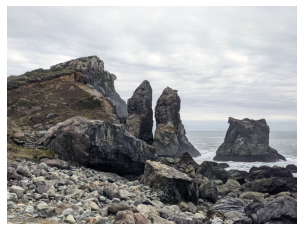

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

* Ahora **usamos una convnet preentrenada**. (En Keras, hay muchas disponibles: **VGG16**, **VGG19**, **Xception**, **ResNet50**, etc., en ImageNet)
* Podemos implementar DeepDream con cualquiera de ellos, pero **el modelo base de elección afectará a las visualizaciones**, porque las diferentes arquitecturas dan como resultado diferentes funciones aprendidas.
* En la práctica, se sabe que **Inception produce DeepDreams atractivos**, por lo que usaremos el modelo Inception V3 que viene con Keras.

**Instanciando el modelo preentrenado `InceptionV3`**

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


* Usaremos nuestra convnet preentrenada para **crear un modelo exactor de características** que **devuelva las activaciones de las diversas capas intermedias**, enumeradas en el **siguiente código**. 
  * Para **cada capa**, elegimos una **puntuación escalar que pondera la contribución de la capa a la pérdida que buscaremos maximizar durante el proceso de ascenso de gradiente**. Si deseáramos una lista completa de nombres de capas que puede usar para elegir nuevas capas con las que probar, simplemente usaríamos ``model.summary()``.

**Configurando la contribución de cada capa a la pérdida de DeepDream**

In [3]:
# Capas para las que tratamos de maximizar la activación, 
# así como su peso en la pérdida total. Podemos modificar 
# estos ajustes para obtener nuevos efectos visuales.
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
# Salidas simbólicas de cada capa
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
# Modelo que devuelve los valores de activación 
# para cada capa de destino (como un diccionario)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

* Ahora, **calcularemos la pérdida**: la **cantidad que buscaremos maximizar durante el proceso de ascenso de gradiente** en cada escala de procesamiento. 
* En lugar de intentar maximizar el valor de un filtro específico en una capa específica para la visualización de filtros, nosotros **maximizaremos simultáneamente la activación de todos los filtros en varias capas**. Específicamente, **maximizaremos una media ponderada de la norma L2 de las activaciones de un conjunto de capas de alto nivel**. 
* El **conjunto** exacto de **capas que elegimos** (así como su **contribución a la pérdida final**) tiene una **gran influencia en las imágenes que podremos producir**, por lo que **queremos que estos parámetros sean fácilmente configurables**. 
* Las **capas inferiores** dan como resultado **patrones geométricos**, mientras que las **capas superiores** dan como resultado **imágenes en las que puede reconocer algunas clases de ImageNet** (por ejemplo, **pájaros** o **perros**). 
* **Comenzaremos** con una **configuración** un tanto **arbitraria** que involucra **cuatro capas**, pero es seguro que querréis explorar muchas configuraciones diferentes más adelante.

**La pérdida de DeepDream**

In [4]:
def compute_loss(input_image):
    # Extrae Activaciones
    features = feature_extractor(input_image)
    # Inicializa la pérdida a cero
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # Evitamos los artefactos de borde al involucrar solo 
        # los píxeles que no están en el borde en la pérdida.
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

Ahora **configuramos el proceso de ascenso de gradiente que ejecutaremos en cada octava**. Veremos esta **técnica de visualización de filtros** en el tema de Visión por Ordenador Avanzado.  El **algoritmo DeepDream es** simplemente **una forma multiescala de visualización de filtros**.

**El proceso de ascenso de gradiente de DeepDream**

In [5]:
import tensorflow as tf

# Hacemos que el paso de entrenamiento sea rápido al compilarlo 
# como una función tf. Usamos la anotación @tf.function
@tf.function
def gradient_ascent_step(image, learning_rate):
    # Calculamos los gradientes de pérdida de 
    # DeepDream con respecto a la imagen actual.
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    # Normalizamos los gradientes (veremos este
    # truco en visión avanzada por ordenador)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

# Esto ejecuta el ascenso de gradiente para una escala (octava) de imagen dada
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    # Actualizamos repetidamente la imagen de 
    # manera que aumente la pérdida de DeepDream.
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        # Nos salimos del bucle si la pérdida cruza un cierto umbral 
        # (la optimización excesiva crearía artefactos de imagen no deseados).
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

* Finalmente, el **bucle externo del algoritmo DeepDream**. **Primero**, definiremos una **lista de escalas** (también llamadas **octavas**) **en las que procesar las imágenes**. 
* **Procesaremos** nuestra **imagen** en **tres "octavas" diferentes**. Para **cada octava sucesiva**, **desde** la más **pequeña** **hasta** la más **grande**, ejecutaremos **20 pasos de ascenso de gradiente a través de ``gradient_ascent_loop()`` para maximizar la pérdida** que definimos previamente.
* **Entre cada octava**, **aumentaremos la escala de la imagen en un 40% (1,4x)**: **comenzaremos procesando una imagen pequeña** y luego la **escalaremos** cada vez más

**El proceso DeepDream: escalas sucesivas de procesamiento espacial (octavas) y reinyección de detalles al escalar**

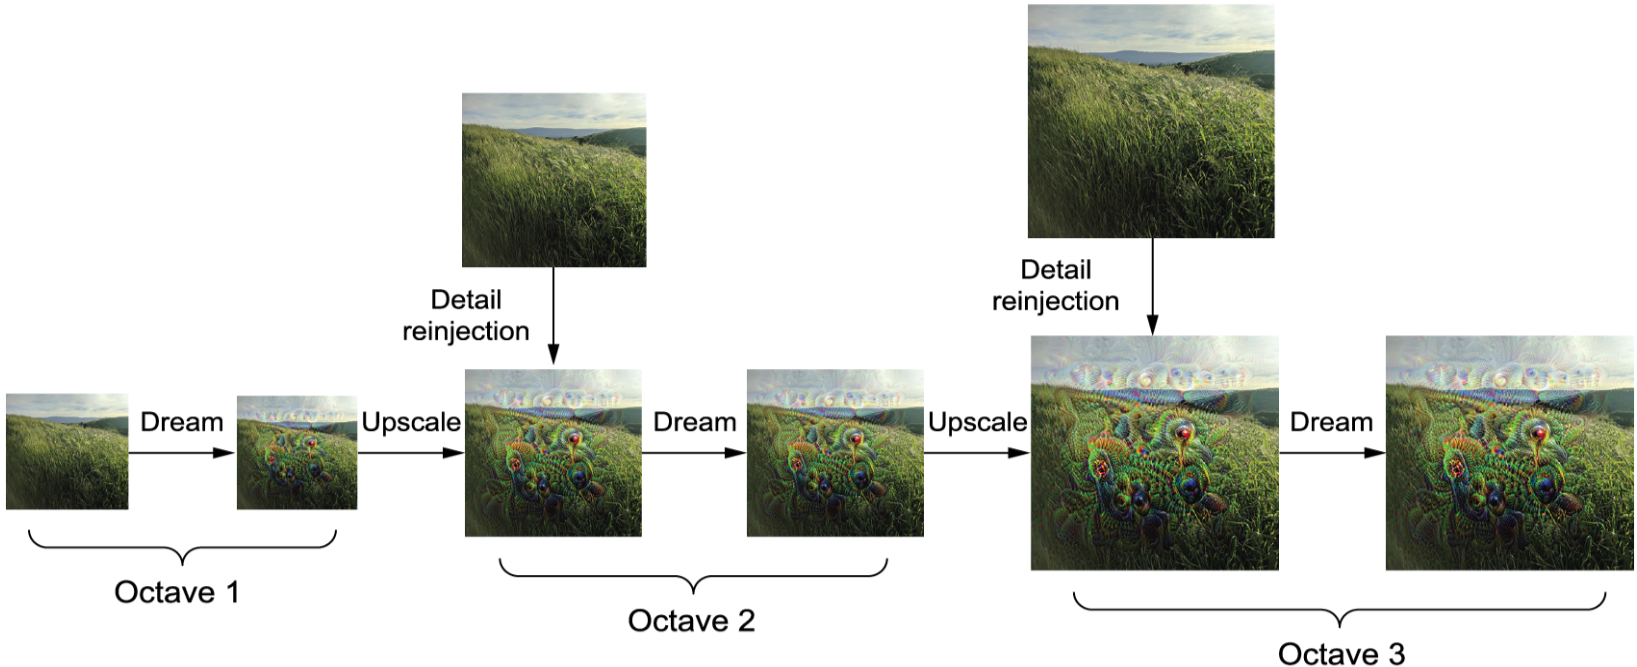

Definimos los parámetros de este proceso en el siguiente código. ¡**Ajustar estos parámetros nos permitirá lograr nuevos efectos**!

In [6]:
# Tamaño de paso de ascenso de gradiente
step = 20.
# Número de escalas (octavas en las que ejecutar el ascenso de gradiente)
num_octave = 3
# Relación de tamaño entre escalas sucesivas
octave_scale = 1.4
# Número de pasos de ascenso de gradiente por escala
iterations = 30
# Detendremos el proceso de ascenso de gradiente 
# para una escala si la pérdida supera este valor.
max_loss = 15.

También vamos a necesitar un par de funciones útiles para cargar y guardar imágenes.

**Utilidades de procesamiento de imágenes**

In [7]:
import numpy as np

# Función útil para abrir, cambiar el tamaño 
# y formatear imágenes en matrices apropiadas
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

# Función útil para convertir una matriz NumPy en una imagen válida
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    # Deshacemos el preprocesamiento de inception v3.
    img /= 2.0
    img += 0.5
    img *= 255.
    # Convertimos a uint8 y recortamos al rango válido [0, 255].
    img = np.clip(img, 0, 255).astype("uint8")
    return img

* Bucle exterior: Para **evitar perder** muchos **detalles de la imagen** después de cada **ampliación** sucesiva (lo que da como resultado imágenes cada vez más **borrosas o pixeladas**), usamos un **truco** simple: **tras cada ampliación**, volveremos a **inyectar los detalles perdidos en la imagen**. , lo cual es posible porque **sabemos cómo debería verse la imagen original a mayor escala**.
* Dado un tamaño de imagen pequeño **S** y un tamaño de imagen más grande **L**, podemos calcular la **diferencia** entre la imagen original redimensionada a tamaño L y la original redimensionada a tamaño S; esta **diferencia cuantifica los detalles perdidos** al pasar de **S** a **L**.

**Ejecutando el ascenso de gradiente sobre múltiples "octavas" sucesivas**

In [8]:
# Cargamos la imagen de prueba
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# Calculamos la forma objetivo de la imagen en diferentes octavas.
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# Hacemos una copia de la imagen (debemos conservar el original).
img = tf.identity(original_img)
# Iteramos sobre las diferentes octavas
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    # Escala la imagen del sueño
    img = tf.image.resize(img, shape)
    # Ejecutamos el ascenso de gradiente, alterando el sueño.
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    # Aumentamos la escala de la versión más 
    # pequeña de la imagen original: estará pixelada.
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    # Calculamos la versión de alta calidad 
    # de la imagen original en este tamaño.
    same_size_original = tf.image.resize(original_img, shape)
    # La diferencia entre los dos es el 
    # detalle que se perdió al aumentar la escala.
    lost_detail = same_size_original - upscaled_shrunk_original_img
    # Re-inyectamos los detalles perdidos en el sueño.
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

# Guardamos el resultado final
keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.17
... Loss value at step 5: 2.50
... Loss value at step 6: 2.83
... Loss value at step 7: 3.19
... Loss value at step 8: 3.55
... Loss value at step 9: 3.87
... Loss value at step 10: 4.20
... Loss value at step 11: 4.55
... Loss value at step 12: 4.94
... Loss value at step 13: 5.28
... Loss value at step 14: 5.65
... Loss value at step 15: 5.98
... Loss value at step 16: 6.32
... Loss value at step 17: 6.65
... Loss value at step 18: 6.98
... Loss value at step 19: 7.30
... Loss value at step 20: 7.64
... Loss value at step 21: 7.96
... Loss value at step 22: 8.27
... Loss value at step 23: 8.55
... Loss value at step 24: 8.86
... Loss value at step 25: 9.10
... Loss value at step 26: 9.43
... Loss value at step 27: 9.68
... Loss value at step 28: 9.92
... Loss value at step 29: 10.17
Process

**NOTA** 
Debido a que la red Inception V3 original fue entrenada para reconocer conceptos en imágenes de tamaño 299 × 299, y dado que el proceso implica reducir las imágenes en un factor razonable, la implementación de **DeepDream produce resultados mucho mejores en imágenes que están entre 300 × 300 y 400 × 400**. Independientemente, podemos ejecutar el mismo código en imágenes de cualquier tamaño y cualquier proporción.

En una GPU, solo lleva unos segundos ejecutar todo. Veamos el resultado de la configuración de nuestro sueño de la imagen de prueba.

**Ejecutando el código de DeepDream en la imagen de prueba**

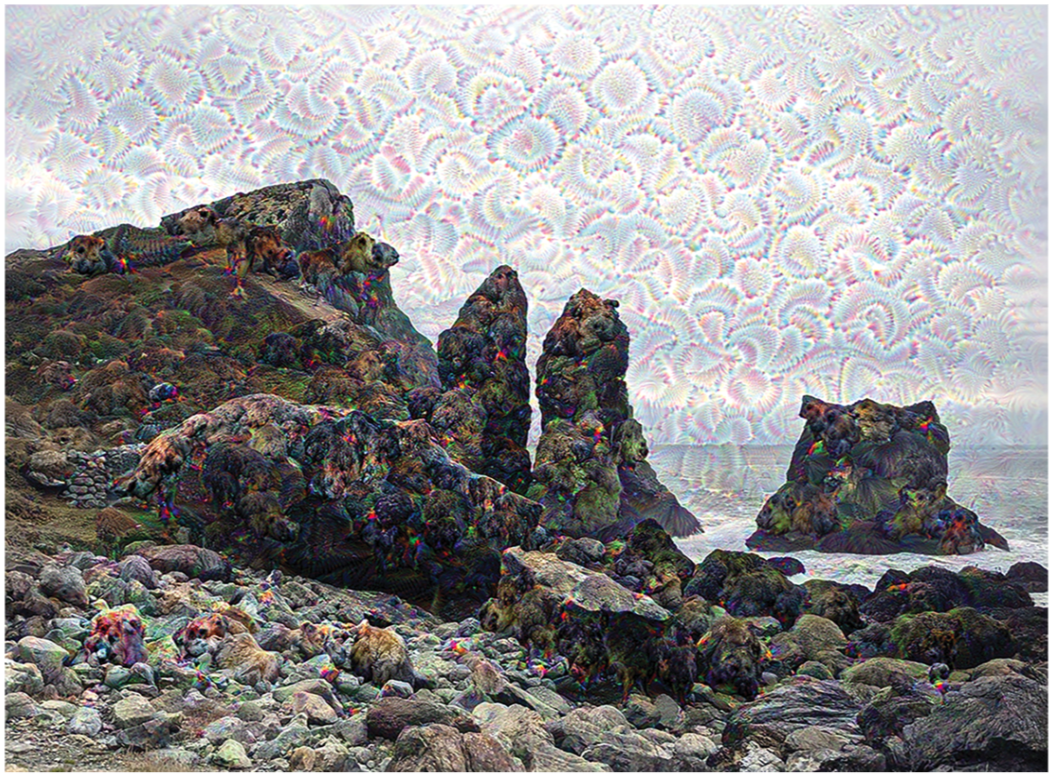

Os sugiero que exploréis lo que se puede hacer **ajustando las capas que usamos en la pérdida**: 
* Las **capas** que están **más abajo** en la red contienen **representaciones más locales** y **menos abstractas** y conducen a **patrones de sueños que parecen más geométricos**.
* Las **capas** que están **más arriba** conducen a **patrones visuales más reconocibles** basados en los **objetos más comunes** que se encuentran en ImageNet, como ojos de perro, plumas de pájaro, etc. 

Podemos usar la **generación aleatoria** de los **parámetros** en el **diccionario ``layers_settings``** para **explorar rápidamente muchas combinaciones de capas diferentes**.

**Probando una variedad de configuraciones de DeepDream en una imagen de ejemplo**

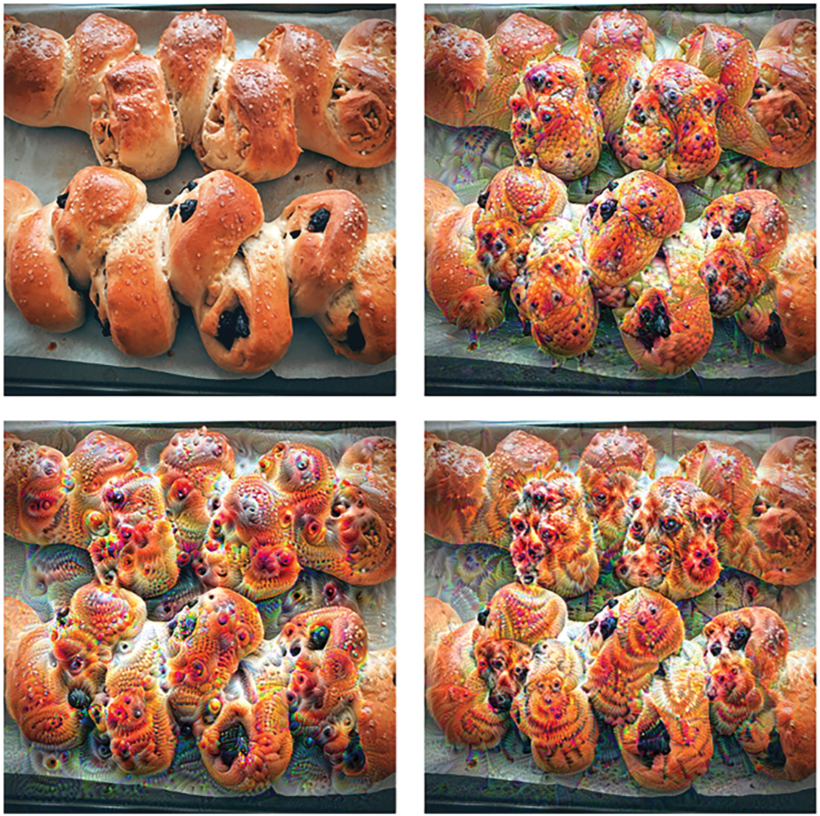

### Resumiendo

* **DeepDream** consiste en ejecutar una **convnet a la inversa** para **generar entradas basadas en las representaciones aprendidas por la red**. 
* Los resultados producidos son divertidos y algo similares a los artefactos visuales inducidos en humanos por la interrupción de la corteza visual a través de **psicodélias**. 
* Hay que tener en cuenta que el **proceso no es específico de los modelos de imagen o incluso de las convnets**. Se puede hacer para **voz**, **música** y mucho más.